In [1]:
import numpy as np
import matplotlib.pyplot as plt
import quandl as qdl

from numpy.lib.recfunctions import append_fields

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Prepare Data

In [2]:
stock_name = 'GOOG'
Next_N_Day = 60

In [3]:
df = qdl.get('WIKI/{}'.format(stock_name))

df

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2014-03-27,568.000,568.00,552.92,558.46,13100.0,0.0,1.0,568.000,568.00,552.92,558.46,13100.0
2014-03-28,561.200,566.43,558.67,559.99,41100.0,0.0,1.0,561.200,566.43,558.67,559.99,41100.0
2014-03-31,566.890,567.00,556.93,556.97,10800.0,0.0,1.0,566.890,567.00,556.93,556.97,10800.0
2014-04-01,558.710,568.45,558.71,567.16,7900.0,0.0,1.0,558.710,568.45,558.71,567.16,7900.0
2014-04-02,565.106,604.83,562.19,567.00,146700.0,0.0,1.0,565.106,604.83,562.19,567.00,146700.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21,1092.740,1106.30,1085.15,1090.88,1640709.0,0.0,1.0,1092.740,1106.30,1085.15,1090.88,1640709.0
2018-03-22,1081.880,1082.90,1045.91,1049.08,2580374.0,0.0,1.0,1081.880,1082.90,1045.91,1049.08,2580374.0
2018-03-23,1047.030,1063.36,1021.22,1021.57,2113497.0,0.0,1.0,1047.030,1063.36,1021.22,1021.57,2113497.0


In [4]:
rec = df.to_records()

rec_close_next_n_day = np.concatenate((rec['Close'][Next_N_Day:], np.zeros(Next_N_Day)), axis=0)
rec = append_fields(rec, 'Close_Next_N_Day', data=rec_close_next_n_day)

rec['Close'].shape, rec['Close_Next_N_Day'].shape

((1007,), (1007,))

In [5]:
l = rec['Close'].shape[0] -Next_N_Day

X = rec['Close'][:l].reshape(-1, 1)
y = rec['Close_Next_N_Day'][:l]

X.shape,  y.shape

((947, 1), (947,))

In [6]:
train_test_size = (0.7, 0.1, 0.2)
random_state = 0

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=train_test_size[0]+train_test_size[1],
                                                    test_size=train_test_size[2],
                                                    random_state=random_state,
                                                   )
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train,
                                                            train_size=train_test_size[0]/(train_test_size[0]+train_test_size[1]),
                                                            test_size=train_test_size[1]/(train_test_size[0]+train_test_size[1]),
                                                            random_state=random_state
                                                           )

X_train.shape, X_validate.shape, X_test.shape

((662, 1), (95, 1), (190, 1))

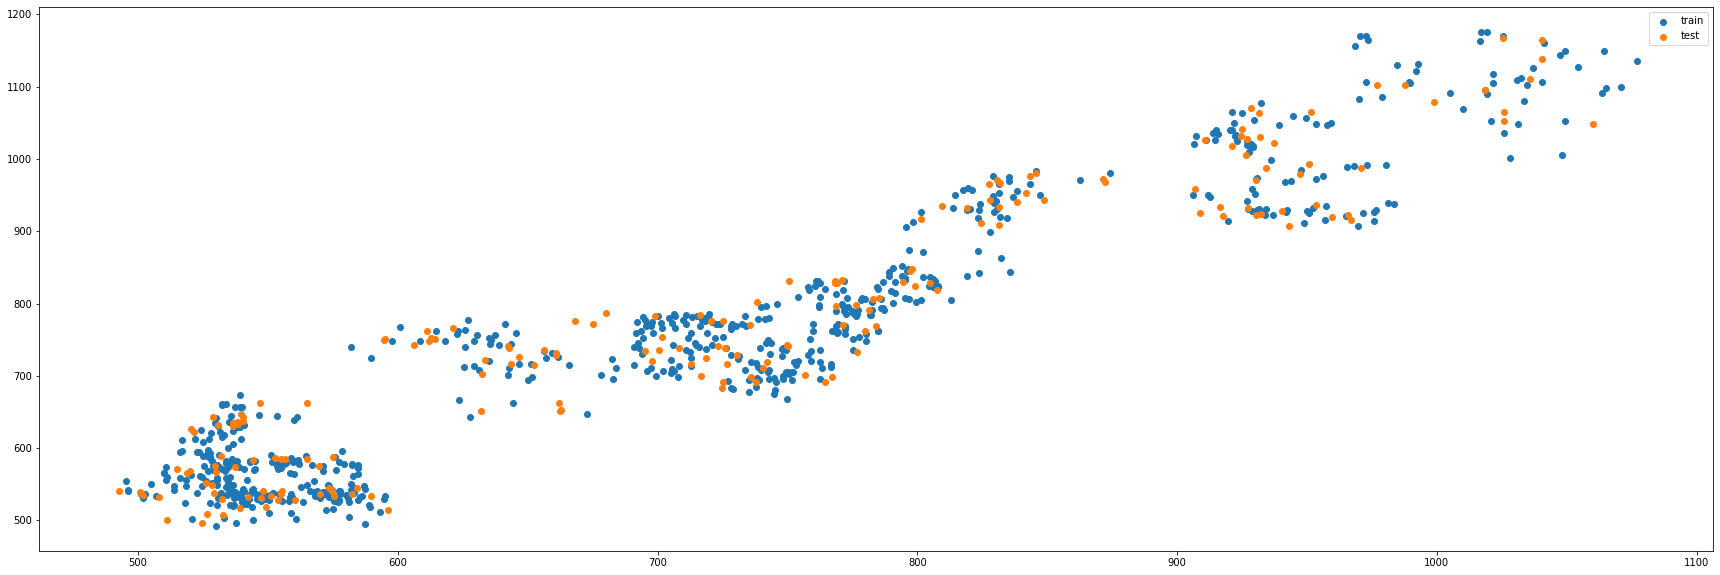

In [7]:
plt.figure(figsize=(30, 10))
plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.legend()

# Cross Validation Prediction

In [8]:
kfold_split = 10

kfold = KFold(n_splits=kfold_split, shuffle=True, random_state=random_state)

In [9]:
svr_c = 1000
svr_gamma = 0.1
svr_degree = 2

lr = LinearRegression()
svr_linear = SVR(kernel='linear', C=svr_c)
svr_rbf = SVR(kernel='rbf', C=svr_c, gamma=svr_gamma)
svr_poly = SVR(kernel='poly', C=svr_c, degree=svr_degree)

In [10]:
model = (lr, svr_linear, svr_rbf, svr_poly)
label = ('lr', 'svr_linear', 'svr_rbf', 'svr_poly')

In [11]:
cv_score = []
for i in model:
    score = cross_val_score(i, X_train, y_train, cv=kfold)
    cv_score.append(score)

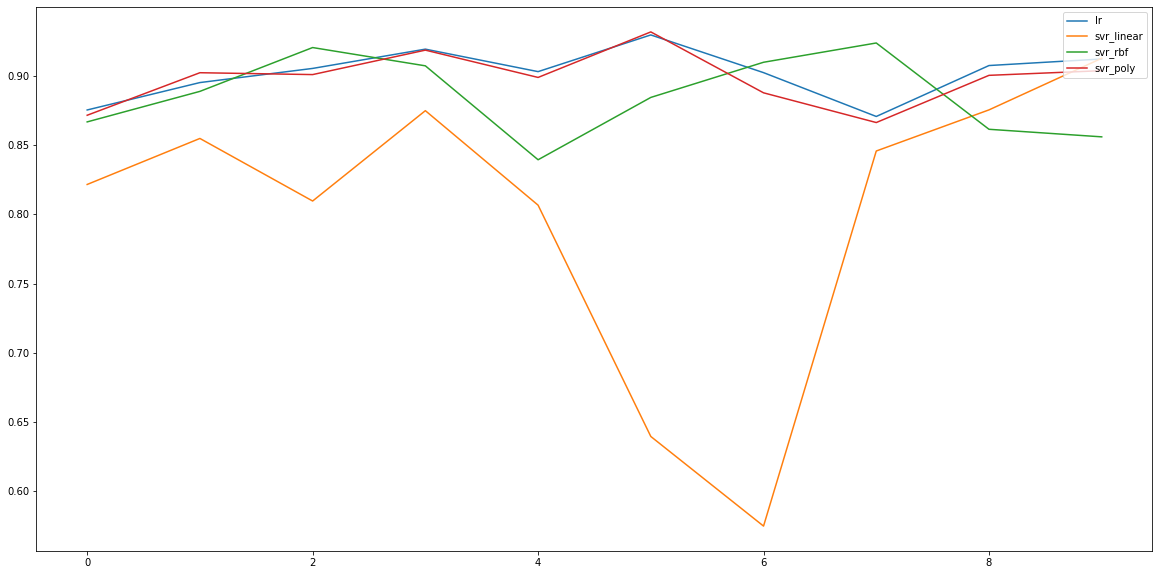

In [12]:
score_T = np.vstack(cv_score).T

plt.figure(figsize=(20, 10))
plot = plt.plot(score_T)
plt.legend(plot, label, loc=1)

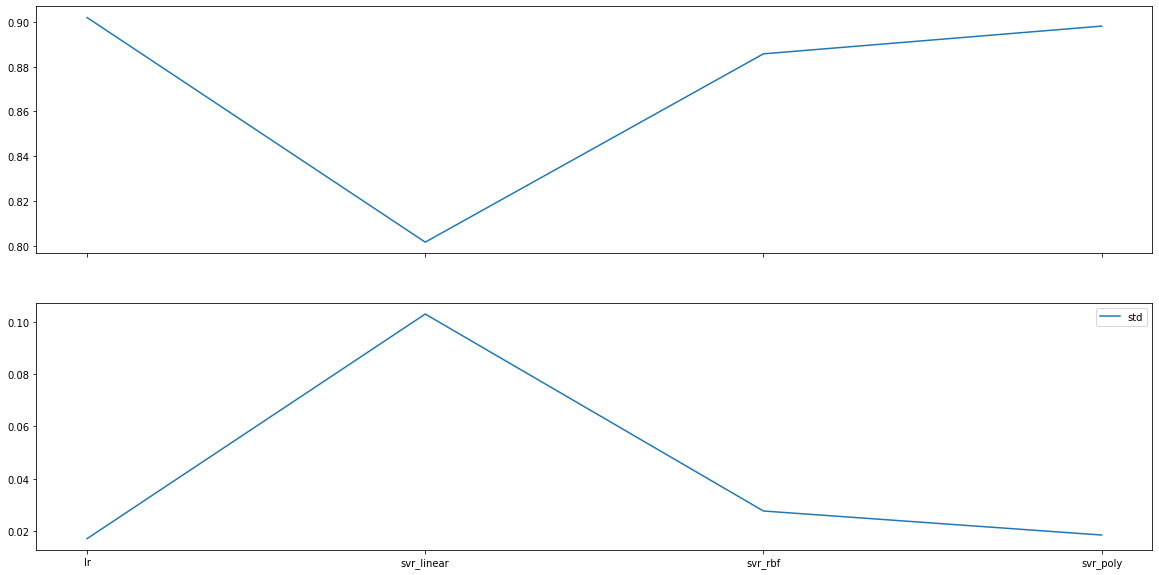

In [13]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=2, sharex=True)
ax[0].plot(score_T.mean(axis=0), label='mean')
ax[1].plot(score_T.std(axis=0), label='std')
plt.xticks(np.arange(len(label)), label)
plt.legend()

In [14]:
mse_val = []
r2s_val = []
mse_test = []
r2s_test = []

for i in model:
    i.fit(X_train, y_train)

    y_hat = i.predict(X_validate)
    mse_val.append(mean_squared_error(y_validate, y_hat))
    r2s_val.append(r2_score(y_validate, y_hat))

    y_hat = i.predict(X_test)
    mse_test.append(mean_squared_error(y_test, y_hat))
    r2s_test.append(r2_score(y_test, y_hat))

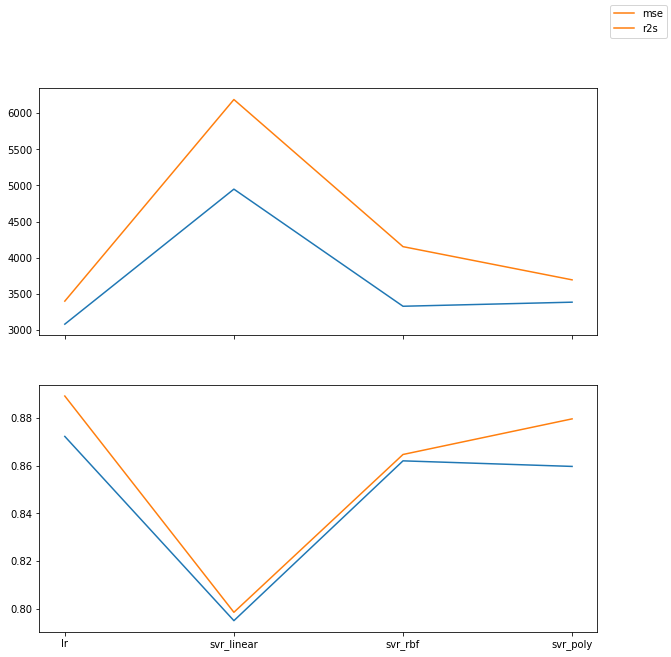

In [15]:
fig, ax = plt.subplots(figsize=(10, 10), nrows=2, sharex=True)
ax[0].plot(mse_val)
ax[0].plot(mse_test, label='mse')
ax[1].plot(r2s_val)
ax[1].plot(r2s_test, label='r2s')
plt.xticks(np.arange(len(label)), label)
fig.legend()

# GridSearchCV

In [16]:
param_grid = [{
    'kernel': ['rbf'],
    'C': [0.1, 1, 100, 1000],
    'gamma': [0.1, 0.1, 0.5]
}]

In [17]:
gsCV_svr = GridSearchCV(estimator=SVR(), param_grid=param_grid, cv=kfold)

In [18]:
gsCV_svr.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.1, 1, 100, 1000], 'gamma': [0.1, 0.1, 0.5],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [19]:
gsCV_svr.best_params_, gsCV_svr.best_score_

({'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}, 0.8857327156258001)

In [20]:
gsCV_svr.fit(X_train, y_train)

y_hat = gsCV_svr.predict(X_validate)
mse_val = mean_squared_error(y_validate, y_hat)
r2s_val = r2_score(y_validate, y_hat)

y_hat = gsCV_svr.predict(X_test)
mse_test = mean_squared_error(y_test, y_hat)
r2s_test = r2_score(y_test, y_hat)

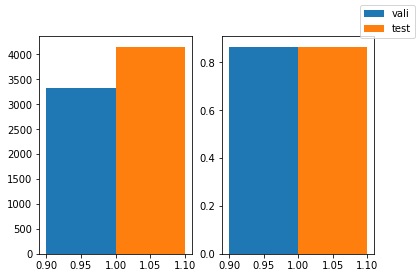

In [21]:
width = 0.1

fig, ax = plt.subplots(ncols=2)
ax[0].bar(1 - width/2, (mse_val), width, label='vali')
ax[0].bar(1 + width/2, (mse_test), width, label='test')
ax[1].bar(1 - width/2, (r2s_val), width)
ax[1].bar(1 + width/2, (r2s_test), width)
fig.legend()